In [313]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Isaak Tracking Data Deep Dive!

We'll be exploring many aspects of Isaak's first few months in the following EDA! Join us on a journey of diapers, sleep, breastfeeding, and growth!

In [314]:
ISAAK_BIRTHDATE = datetime.fromisoformat("2024-01-30")
BRIAN_BACK_TO_WORK_DATE = datetime.fromisoformat("2024-05-06")

In [315]:
df = pd.read_csv("isaak_huckleberry_2024-06-08.csv")

In [316]:
# First look at data table
df

,Type,Start,End,Duration,Start Condition,Start Location,End Condition,Notes
0,Diaper,2024-06-08 17:48,NaN,NaN,NaN,NaN,Poo:medium,NaN
1,Diaper,2024-06-08 16:49,NaN,NaN,NaN,NaN,Pee:medium,NaN
2,Sleep,2024-06-08 16:11,2024-06-08 16:43,00:32,NaN,NaN,NaN,NaN
3,Sleep,2024-06-08 13:21,2024-06-08 13:53,00:32,NaN,NaN,NaN,NaN
4,Sleep,2024-06-08 10:22,2024-06-08 11:02,00:40,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3433,Feed,2024-01-31 11:35,2024-01-31 11:45,00:10,00:05R,Breast,00:05L,NaN
3434,Feed,2024-01-31 07:50,2024-01-31 08:00,00:10,00:10R,Breast,Null l,NaN
3435,Feed,2024-01-31 07:35,2024-01-31 07:55,00:20,Null r,Breast,00:20L,NaN
3436,Feed,2024-01-31 03:50,2024-01-31 04:00,00:10,Null r,Breast,00:10L,NaN


We've been measuring _many_ data points on Isaak...

In [317]:
print(f"In total, we've recorded: {len(df):,} bits of data since Isaak's birth!")

In total, we've recorded: 3,438 bits of data since Isaak's birth!


Seems like a full time job, lol!

In [318]:
# Look at rough counts on categories
df.groupby("Type").count()

,Start,End,Duration,Start Condition,Start Location,End Condition,Notes
Type,,,,,,,
Bath,4,1,1,0,0,0,0
Diaper,1137,0,195,188,0,1137,4
Feed,1314,994,994,1314,1314,1314,1
Growth,26,0,0,26,14,13,0
Indoor play,34,30,30,0,0,0,1
Pump,281,226,226,281,0,0,1
Sleep,630,630,630,1,2,2,0
Story time,1,1,1,0,0,0,0
Tummy time,11,9,9,0,0,0,0


In [319]:
# Convert to datetime format
df[["Start", "End"]] = df[["Start", "End"]].apply(pd.to_datetime)

In [320]:
df["Date"] = df["Start"].apply(lambda x: x.date())

## Diaper Deep Dive

How many diapers have we changed in TOTAL?

In [321]:
diapers_by_date = (
    df.query("Type == 'Diaper'").groupby("Date")["Type"].count().reset_index()
)
diapers_by_date.rename(columns={"Type": "Diapers"}, inplace=True)

In [322]:
print(f"Total diapers changed to-date: {diapers_by_date["Diapers"].sum()}")

Total diapers changed to-date: 1137


That's _a lot_ of diapers!!! Now, what was the most diapers we changed in a single day?

In [323]:
print(
    f"Busiest diaper change day(s):\n\n {diapers_by_date.loc[diapers_by_date["Diapers"] == diapers_by_date["Diapers"].max()].to_string(index=False)}"
)

Busiest diaper change day(s):

       Date  Diapers
2024-02-11       17
2024-02-15       17


Yep, the early days were busy!

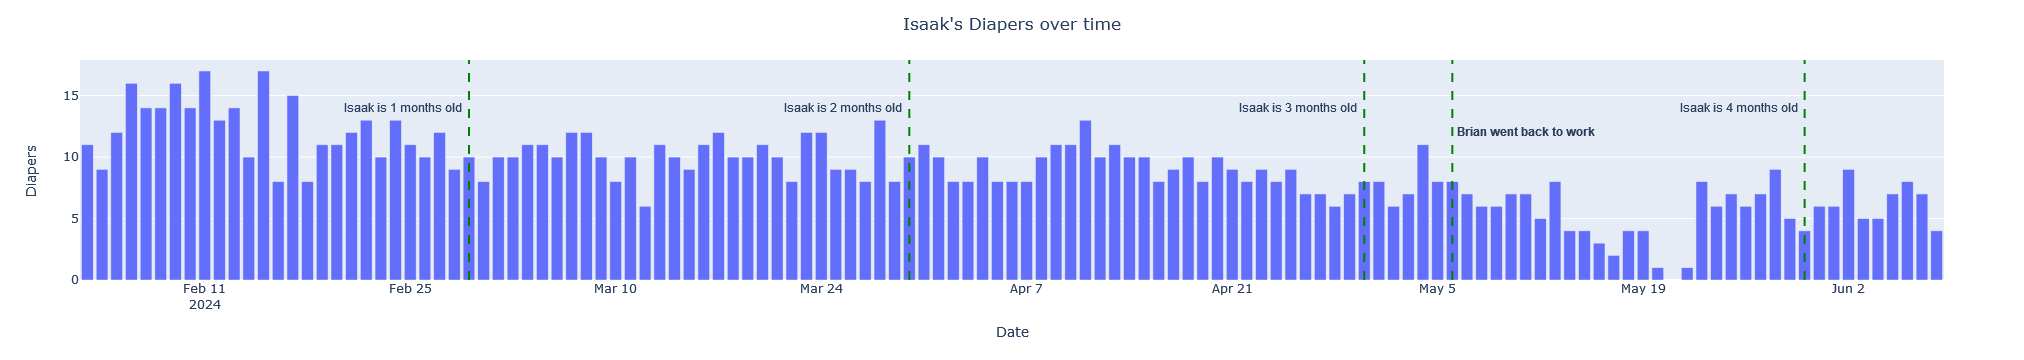

In [324]:
fig = px.bar(diapers_by_date, x="Date", y="Diapers")
fig.update_layout(title_text="Isaak's Diapers over time", title_x=0.5)
fig.add_vline(x=BRIAN_BACK_TO_WORK_DATE, line_dash="dash", line_color="green")
fig.add_annotation(
    x=BRIAN_BACK_TO_WORK_DATE,
    text="<b>Brian went back to work</b>",
    xshift=75,
    y=12,
    font={"family": "Arial"},
    showarrow=False,
)

for month in [1, 2, 3, 4]:
    months_old = ISAAK_BIRTHDATE + relativedelta(months=month)
    fig.add_vline(x=months_old, line_dash="dash", line_color="green")
    fig.add_annotation(
        x=months_old,
        text=f"Isaak is {month} months old",
        xshift=-65,
        y=14,
        font={
            "family": "Arial",
        },
        showarrow=False,
    )
fig.show()
fig.write_html("isaak_diapers_over_time.html")

In [325]:
df = pd.merge(
    df,
    df["End Condition"]
    .str.extractall(r"(?P<diaper_type>[a-zA-z]{3}):(?P<diaper_size>[a-z]+)")
    .apply(lambda x: x.str.lower())
    .reset_index("match"),
    left_index=True,
    right_index=True,
    how="left",
)
df.drop("match", axis=1, inplace=True)

In [326]:
diaper_type_by_date = (
    df.groupby(["Date", "diaper_type", "diaper_size"])["Type"].count().reset_index()
)
diaper_type_by_date.rename(columns={"Type": "Diapers"}, inplace=True)

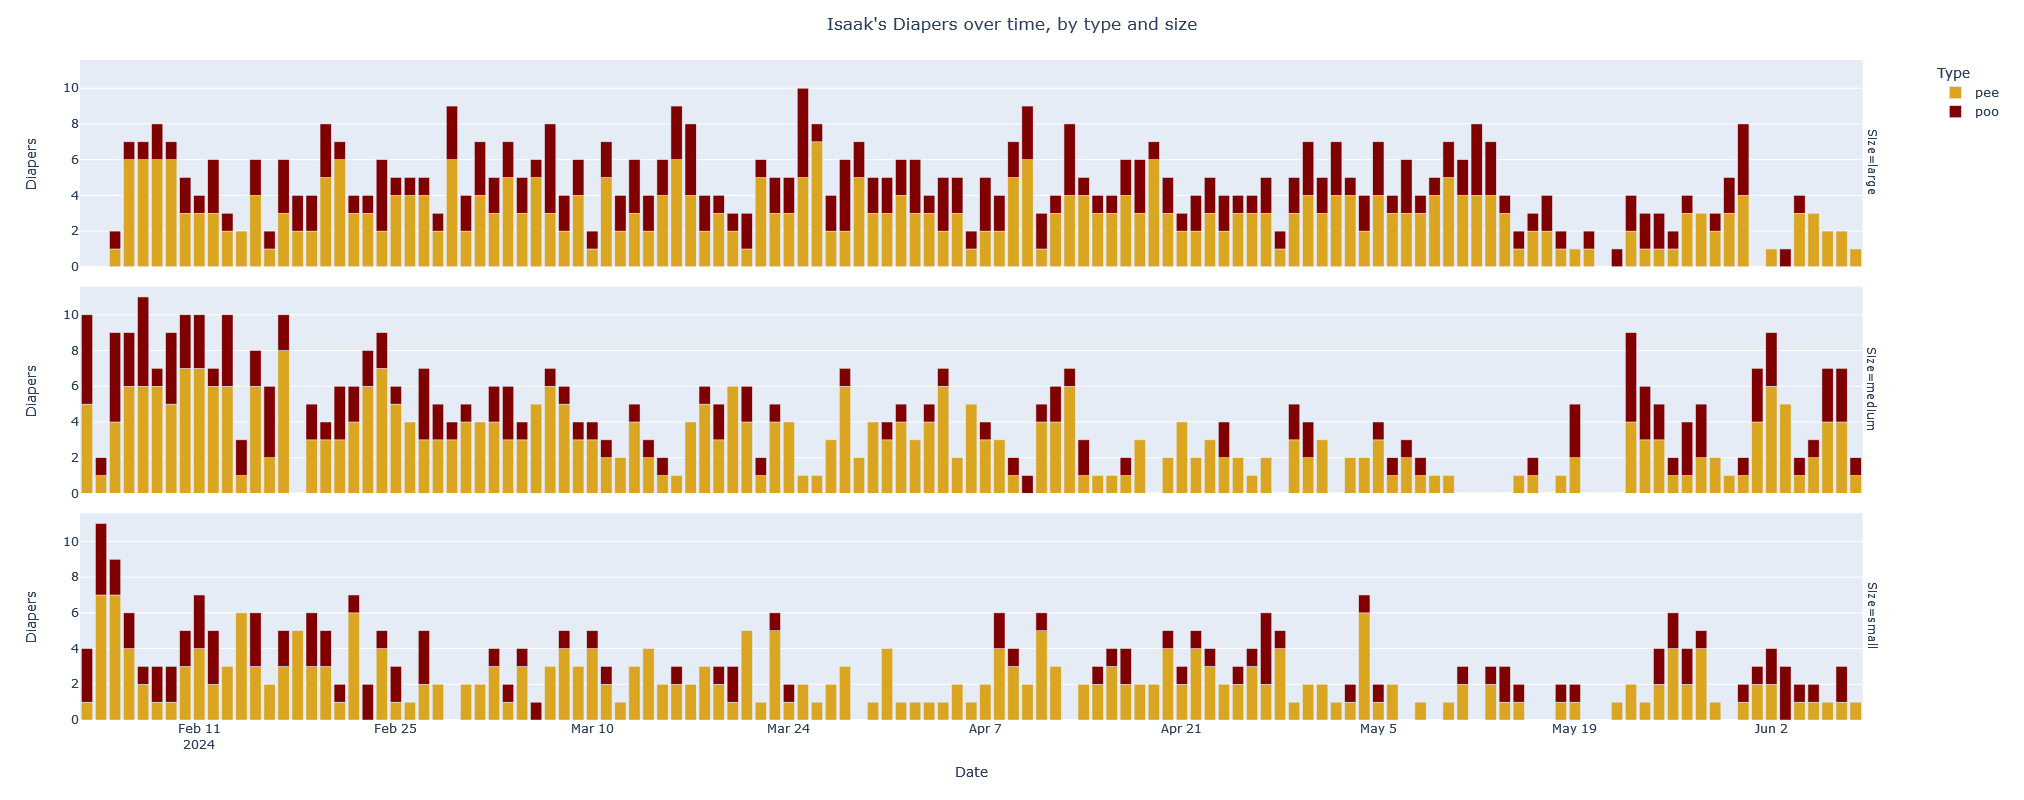

In [328]:
fig = px.bar(
    diaper_type_by_date,
    x="Date",
    y="Diapers",
    color="diaper_type",
    facet_row="diaper_size",
    color_discrete_map={"pee": "goldenrod", "poo": "maroon"},
    category_orders={"diaper_size": ["large", "medium", "small"]},
    labels={"diaper_type": "Type", "diaper_size": "Size"},
)
fig.update_layout(title_text="Isaak's Diapers over time, by type and size", title_x=0.5)
fig.update_layout(height=800)
fig.show()
fig.write_html("isaak_diapers_over_time_by_type_and_size.html")

I've had this idea to _encode_ the diaper size as an integer, such that you can look at "total output" for a given day, instead of trying to mentally map what `small`, `medium`, and `large` mean. Let's try it!

In [329]:
def encode_diaper_size(s: str) -> int:
    diaper_size_map = {"small": 1, "medium": 2, "large": 3}
    return diaper_size_map[s.lower()]

In [330]:
diaper_type_by_date["diaper_size_encoded"] = diaper_type_by_date["diaper_size"].apply(
    encode_diaper_size
)
diaper_type_by_date["diaper_output"] = (
    diaper_type_by_date["diaper_size_encoded"] * diaper_type_by_date["Diapers"]
)
diaper_output = diaper_type_by_date.groupby("Date")["diaper_output"].sum().reset_index()

# Compute some quick stats
diaper_output_mean = np.mean(diaper_output["diaper_output"])
diaper_output_std = np.std(diaper_output["diaper_output"])

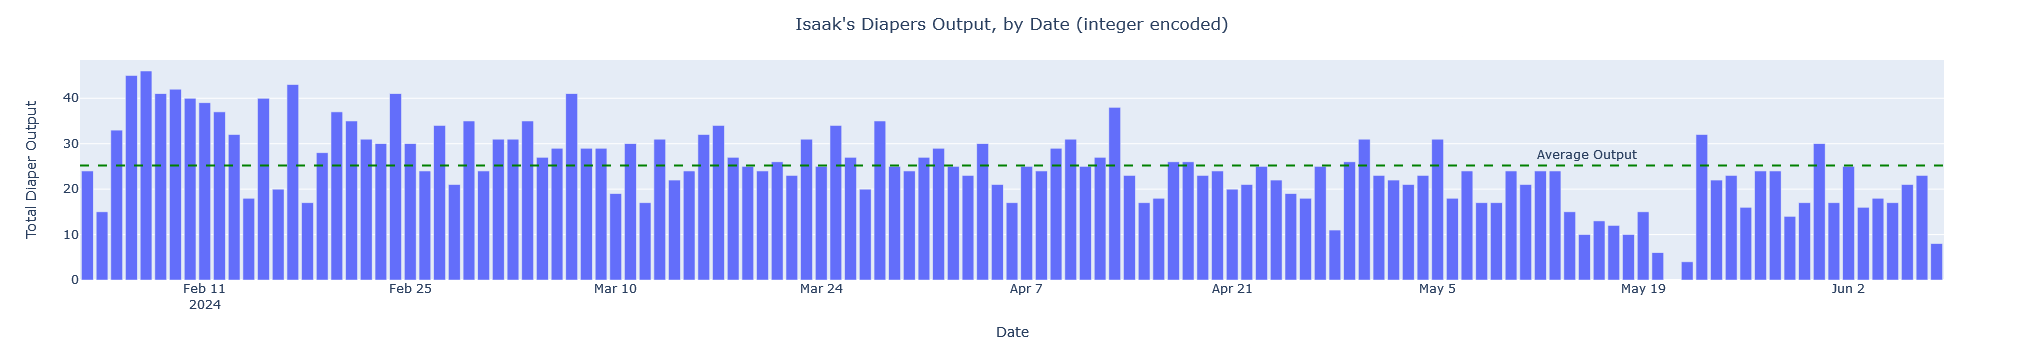

In [331]:
fig = px.bar(
    diaper_output,
    x="Date",
    y="diaper_output",
    labels={"diaper_output": "Total Diaper Output"},
)
fig.add_hline(
    y=diaper_output_mean,
    line_dash="dash",
    line_color="green",
    annotation=dict(text="Average Output", xshift=-300),
)
fig.update_layout(
    title_text="Isaak's Diapers Output, by Date (integer encoded)", title_x=0.5
)
fig.show()
fig.write_html("isaak_diapers_encoded_output.html")

We gotta, _just gotta_ look at a distribution of this!

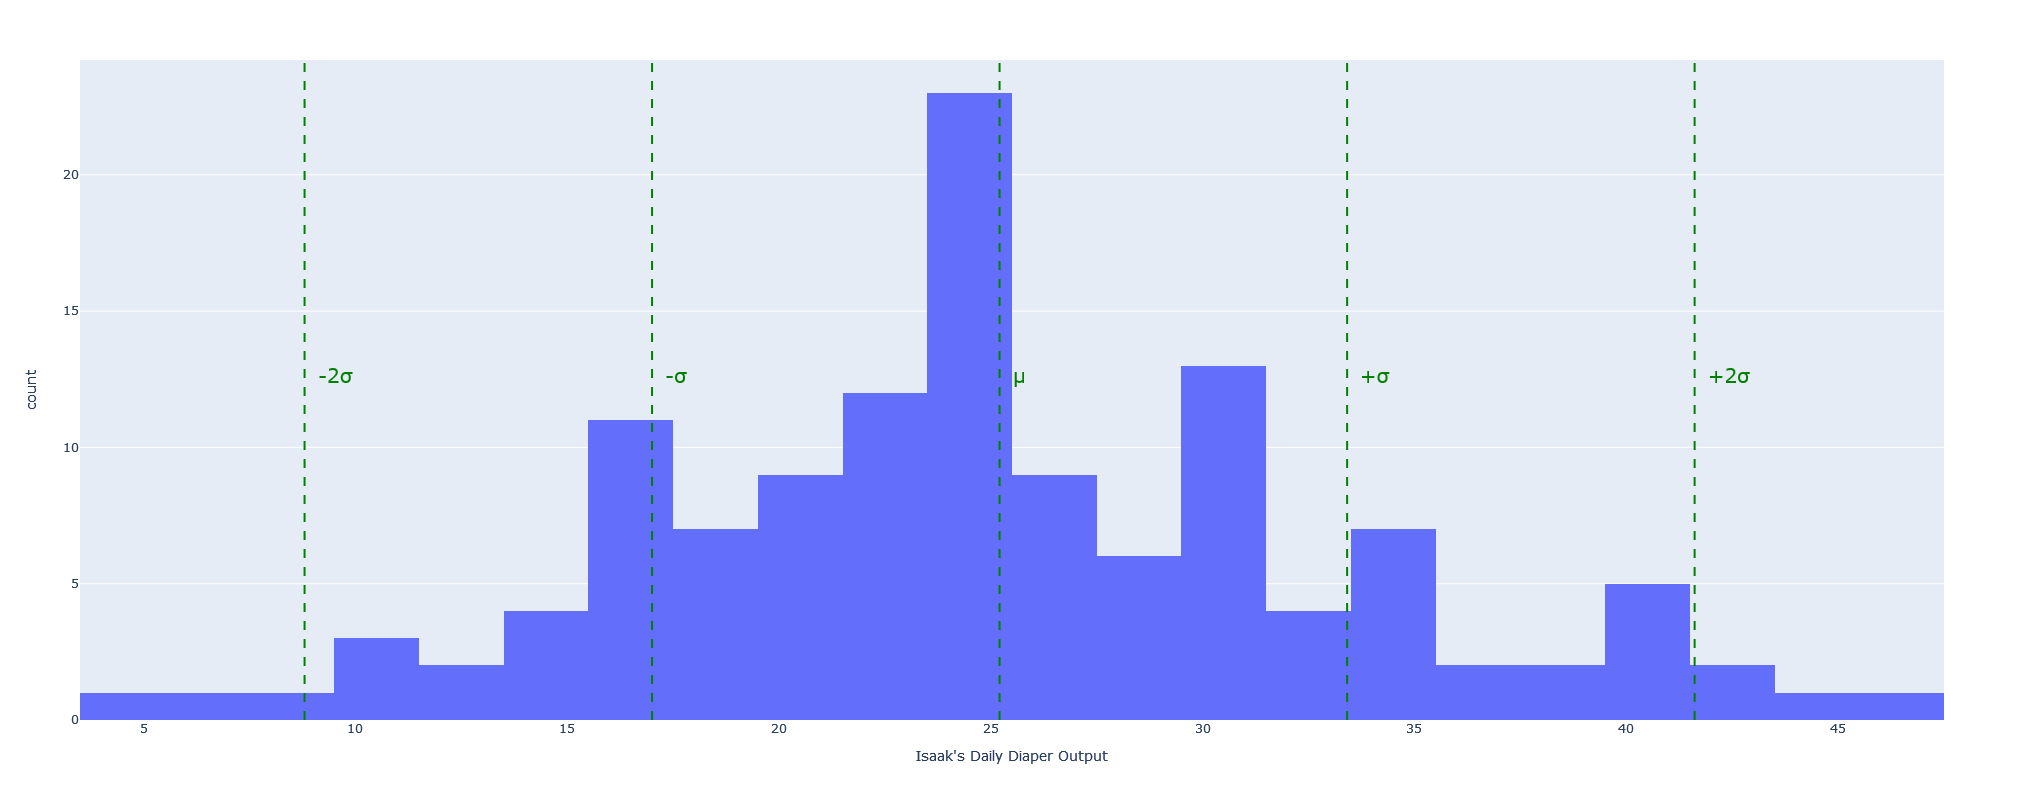

In [333]:
fig = px.histogram(diaper_output["diaper_output"], nbins=30)
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_title="Isaak's Daily Diaper Output", height=800)
fig.add_vline(
    diaper_output_mean,
    line_dash="dash",
    line_color="green",
    annotation=dict(
        text="μ", xshift=10, yshift=-300, font=dict(size=20, color="green")
    ),
)
fig.add_vline(
    diaper_output_mean + diaper_output_std,
    line_dash="dash",
    line_color="green",
    annotation=dict(
        text="+σ", xshift=10, yshift=-300, font=dict(size=20, color="green")
    ),
)
fig.add_vline(
    diaper_output_mean - diaper_output_std,
    line_dash="dash",
    line_color="green",
    annotation=dict(
        text="-σ", xshift=10, yshift=-300, font=dict(size=20, color="green")
    ),
)
fig.add_vline(
    diaper_output_mean + 2 * diaper_output_std,
    line_dash="dash",
    line_color="green",
    annotation=dict(
        text="+2σ", xshift=10, yshift=-300, font=dict(size=20, color="green")
    ),
)
fig.add_vline(
    diaper_output_mean - 2 * diaper_output_std,
    line_dash="dash",
    line_color="green",
    annotation=dict(
        text="-2σ", xshift=10, yshift=-300, font=dict(size=20, color="green")
    ),
)
fig.show()
fig.write_html("isaak_diapers_encoded_output_histogram.html")

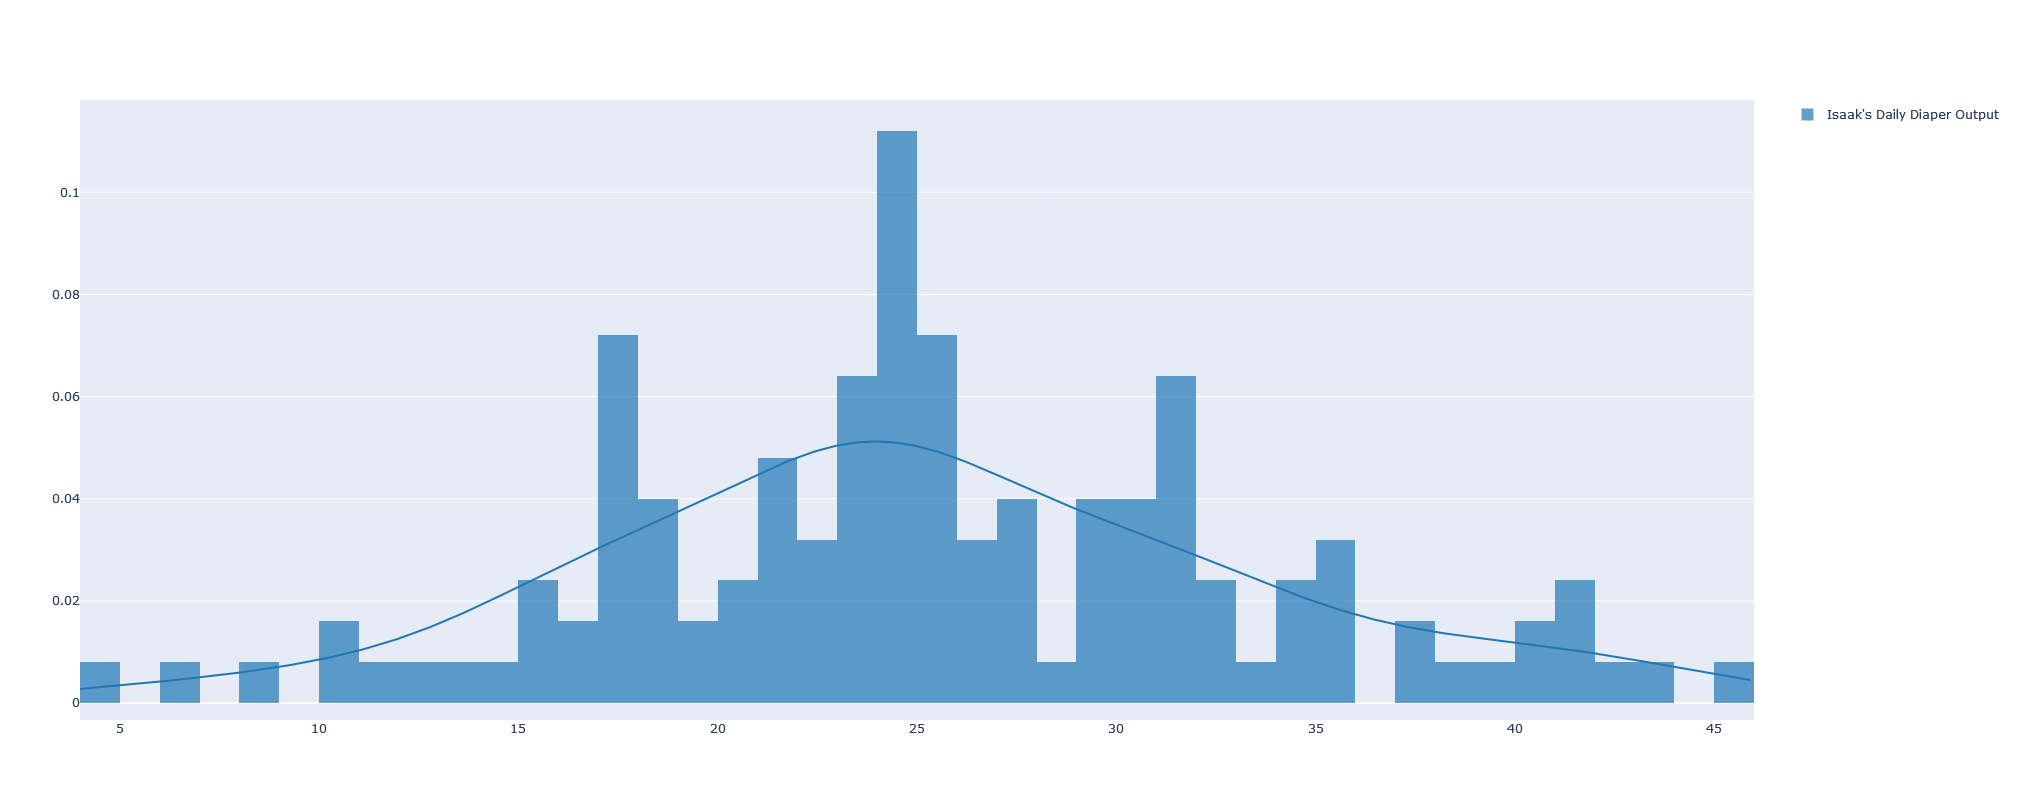

In [334]:
fig = ff.create_distplot(
    [diaper_output["diaper_output"]],
    group_labels=["Isaak's Daily Diaper Output"],
    show_rug=False,
)
fig.update_layout(height=800)
fig.show()
fig.write_html("isaak_diapers_encoded_output_distplot.html")

Out of curiosity, I wonder if the max "encoded output" is the same as the max number of diapers day?